In [1]:
import numpy as np 
from scipy.special import softmax 
import time 

from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 

from utils.env import frozen_lake
from utils.viz import viz 
viz.get_style()

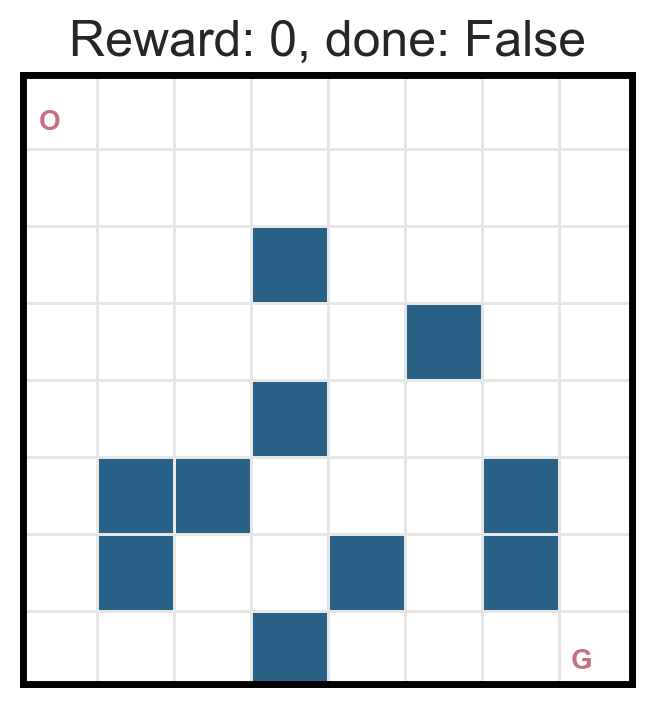

In [2]:
seed = 1234 
env = frozen_lake(seed=seed)
env.reset()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
env.render(ax)

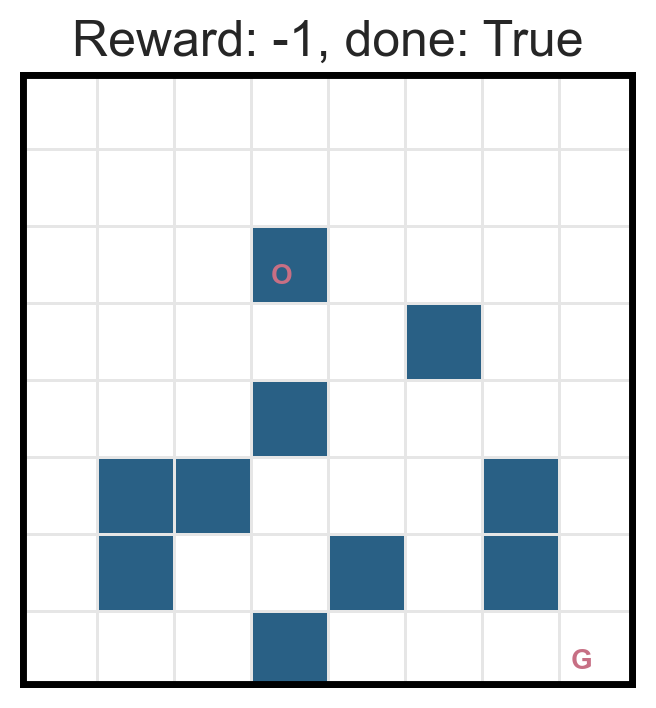

In [3]:
done = False
acts = [3, 3, 3, 1, 1, 1]
for a in acts:
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    clear_output(True)
    env.render(ax)
    plt.show()
    if done: break
    _, _, done =env.step(a)
    time.sleep(.1)
    

## Have a look at the environment 

Actions: 

* 0: up
* 1: down
* 2: left
* 3: right

In [4]:
## check transition function
# check p_trans of a surface
# p(s'|s,a)
env.p_s_next(s=1, a=2).round(2)

array([0.8 , 0.07, 0.07, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [6]:
# check p trans of a hole
env.p_s_next(s=19, a=0).round(2)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
# check reward function of a surface, hole, and goal 
env.r(2), env.r(19), env.r(63), 

((0, False), (-1, True), (1, True))

## Policy evaluation 

In [8]:
# a random policy 
rng = np.random.RandomState(1234)
pi_rand = softmax(rng.rand(env.nS, env.nA)*5, axis=1)
pi_rand

array([[0.0307586 , 0.26483744, 0.10534188, 0.59906209],
       [0.43947039, 0.0347665 , 0.03544608, 0.49031703],
       [0.5511548 , 0.36539615, 0.02739623, 0.05605283],
       [0.34377074, 0.39788796, 0.07180213, 0.18653917],
       [0.08613111, 0.00745807, 0.33181846, 0.57459236],
       [0.17378323, 0.60811237, 0.04086545, 0.17723895],
       [0.55593416, 0.13588923, 0.03812851, 0.2700481 ],
       [0.04514386, 0.15856537, 0.71430541, 0.08198537],
       [0.4416741 , 0.01642276, 0.27073458, 0.27116856],
       [0.01433183, 0.48924366, 0.04378215, 0.45264235],
       [0.03927629, 0.07318646, 0.03690516, 0.85063209],
       [0.37784904, 0.27808357, 0.0239985 , 0.32006889],
       [0.12952563, 0.30808345, 0.04359786, 0.51879306],
       [0.1249935 , 0.00763207, 0.1617007 , 0.70567373],
       [0.14151595, 0.38768729, 0.32825822, 0.14253854],
       [0.10281175, 0.56184634, 0.26964704, 0.06569487],
       [0.04412666, 0.00854072, 0.06240959, 0.88492302],
       [0.02965145, 0.02898278,

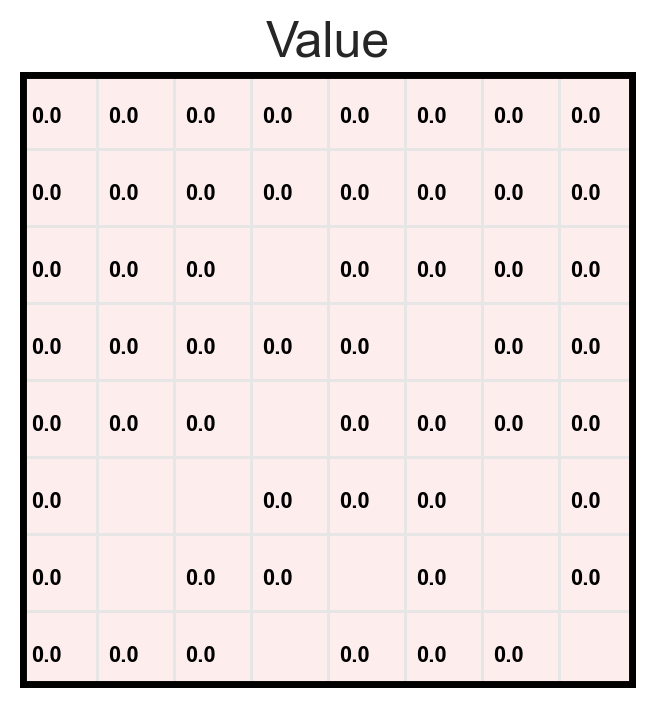

In [10]:
fig, ax = plt.subplots(1,1,figsize=(4, 4))
env.show_v(ax, np.zeros([64]))

In [21]:
def policy_eval(pi, env, theta=1e-4, gamma=.99):

    # initialize V(s), arbitrarily except V(terminal)=0
    V = rng.randn(64,)

    # except v(terminal) = 0
    for s in env.s_termination:
        V[s] = 0
        
    # loop until convergence
    while True: 
        delta = 0
        for s in env.S: # loop all states
            if s not in env.s_termination:
                v_old = V[s].copy()
                v_new = 0
                for a in env.A: # loop action
                    p = env.p_s_next(s, a) # obtain transition
                    for s_next in env.S:
                        r, done = env.r(s_next)
                        v_new = v_new + pi[s,a]*p[s_next]*(r+(1-done)*gamma*V[s_next])
                V[s] = v_new

                delta = np.max([delta, np.abs(v_old-v_new)])
        
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        clear_output(True)
        env.show_v(ax, V)
        time.sleep(1)
        plt.show()

        # check convergence
        if delta < theta:
            break 
    
    return V

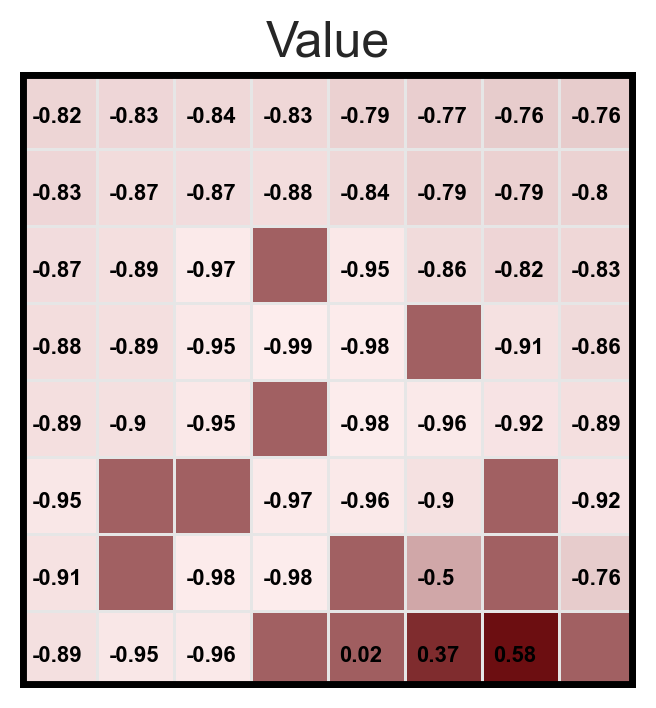

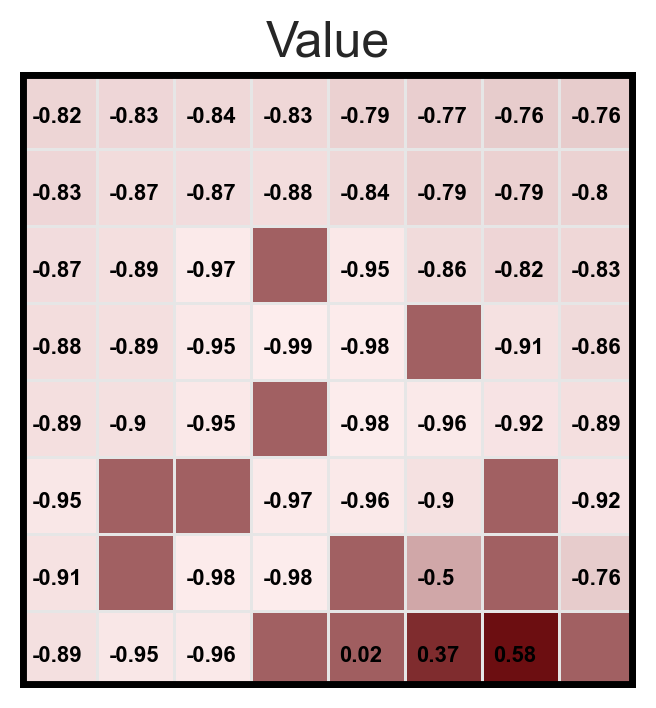

In [22]:
V = policy_eval(pi_rand, env)

In [ ]:
def policy_improve(pi, V, env, theta=1e-4, gamma=.99):
    pi_old = pi.copy()
    for s in env.S:
        q = np.zeros([env.nA])
        for a in env.A:
            for s_next in env.S:
                ##################################
                #         Your Answer            #
                ##################################
        # get new policy 
        ##################################
        #         Your Answer            #
        ##################################
    
    # check stable
    ##################################
    #         Your Answer            #
    ##################################

    return pi, stable  

## Policy iteration

In [ ]:
def policy_iter(env, seed=1234):

    rng = np.random.RandomState(seed)

    # initialize V(s), arbitrarily except V(terminal)=0
    V = rng.rand(env.nS) * 0.001
    # except v(terminal) = 0
    for s in env.s_termination:
        V[s] = 0
    # initialize π(s), arbitrarily
    pi = softmax(rng.rand(env.nS, env.nA)*5, axis=1)

    while True: 

        V = policy_eval(pi, V, env)
        pi, stable = policy_improve(pi, V, env)
        if stable: break 

    return V, pi 

In [ ]:
V1, pi1 = policy_iter(env)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
env.show_v(ax, V1)
ax = axs[1]
env.show_pi(ax, pi1)

## Value iteration

In [ ]:
def value_iter(env, seed=1234, theta=1e-4, gamma=.99):
    
    rng = np.random.RandomState(seed)
    # initialize V(s), arbitrarily except V(terminal)=0
    ##################################
    #         Your Answer            #
    ##################################
    # init policy 
    ##################################
    #         Your Answer            #
    ##################################
    # loop until converge
    while True:
        delta = 0
        for s in env.S:
            v_old = V[s].copy()
            for a in env.A:
                p = env.p_s_next(s, a)
                for s_next in env.S:
                    ##################################
                    #         Your Answer            #
                    ##################################
            # calculate V
            ##################################
            #         Your Answer            #
            ##################################
            # get new policy 
            ##################################
            #         Your Answer            #
            ##################################
            delta = np.max([delta, np.abs(V[s] - v_old)])

        if delta < theta:
            break 
    for s in env.s_termination:
        V[s] = 0
    return V, pi 
        

In [ ]:
V2, pi2 = value_iter(env)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
env.show_v(ax, V2)
ax = axs[1]
env.show_pi(ax, pi2)

## Q learning, TD learning

In [ ]:
def Q_learning(env, alpha=.05, eps=.1, gamma=.99, max_epi=100, seed=1234, theta=1e-4):
    # rng
    rng = np.random.RandomState(seed)
    # initialize Q
    Q = np.zeros([env.nS, env.nA])
    for _ in range(max_epi):
        s, r, done = env.reset()
        t = 0 
        q_old = Q.copy()
        while True:
            # sample At, observe Rt, St+1
            ##################################
            #         Your Answer            #
            ##################################
            t += 1
            if done:
                break 
        if (np.abs(q_old - Q)<theta).all():
            break
    pi = np.eye(env.nA)[np.argmax(Q, axis=1)]
    return Q, pi

In [ ]:
Q, pi3 = Q_learning(env)
V3 = Q.max(1)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
env.show_v(ax, V3)
ax = axs[1]
env.show_pi(ax, pi3)